# Importing libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import scikitplot as skplt

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, recall_score

#from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

In [2]:
data = pd.read_csv("../input/heart-disease-prediction-using-logistic-regression/framingham.csv")
data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


# Data cleaning

### Droping columns

In [3]:
data1 = data.copy()

In [4]:
data1 = data.drop(["education"],axis=1)

In [5]:
data1.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
data1.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [7]:
data1 = data1.dropna(subset=["cigsPerDay"])
data1 = data1.dropna(subset=["BPMeds"])
data1 = data1.dropna(subset=["totChol"])
data1 = data1.dropna(subset=["BMI"])
data1 = data1.dropna(subset=["heartRate"])

### Imputing missing value in data

In [8]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] ##all the values of column(na_target) that are not missing.
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns] ##all the other column(leaving na_target) with no missing value
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [9]:
data1 = knn_impute(data1,"glucose")

In [10]:
data1.isna().sum().sum()

0

In [11]:
data1 = data1.reset_index(drop=True)

# Picking target

In [12]:
data2 = data1.copy()

In [13]:
target = data2["TenYearCHD"]
target

0       0
1       0
2       0
3       1
4       0
       ..
4083    1
4084    1
4085    0
4086    0
4087    0
Name: TenYearCHD, Length: 4088, dtype: int64

In [14]:
data2 = data2.drop(["TenYearCHD"],axis=1)

In [15]:
data2.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


# Data visualization

Text(0.5, 0, 'Heart Attack risk')

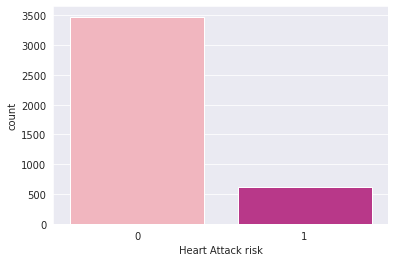

In [16]:
sns.countplot(x = target, palette= 'RdPu')
plt.xlabel('Heart Attack risk')

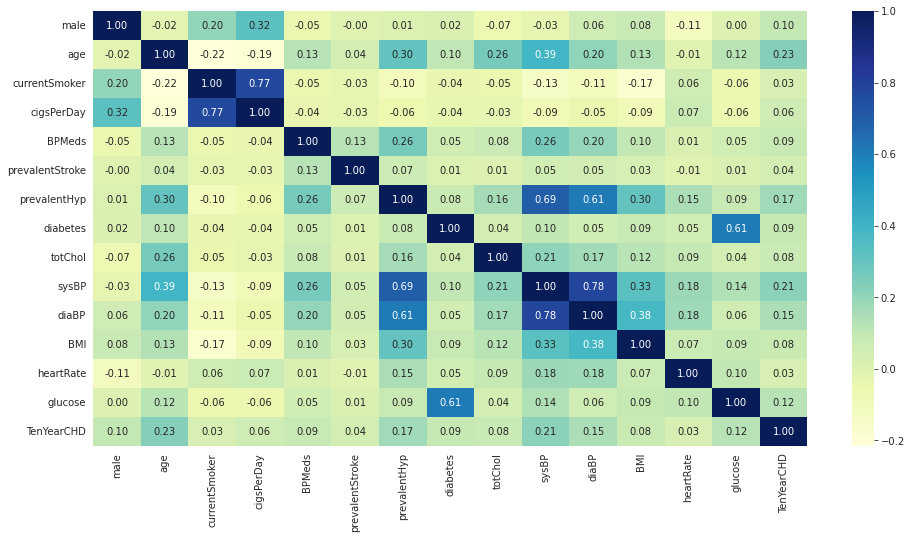

In [17]:
plt.figure(figsize= (16, 8))
sns.heatmap(data1.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

# Feature Scaling

In [18]:
data3 = data2.copy()

In [19]:
sc = StandardScaler()
data3[["age",
"cigsPerDay",
"totChol",
"sysBP",
"diaBP",
"BMI",
"heartRate",
"glucose"]] = sc.fit_transform(data3[["age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"]])

In [20]:
data3.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,-1.229971,0,-0.755064,0.0,0,0,0,-0.937495,-1.197246,-1.088672,0.287219,0.345170,-0.208090
1,0,-0.410334,0,-0.755064,0.0,0,0,0,0.299536,-0.512432,-0.159498,0.718865,1.588610,-0.251529
2,1,-0.176152,1,0.924270,0.0,0,0,0,0.187079,-0.215679,-0.243968,-0.112544,-0.069310,-0.512159
3,0,1.346031,1,1.763937,0.0,0,1,0,-0.262751,0.811541,1.023087,0.682077,-0.898269,0.921310
4,0,-0.410334,1,1.176170,0.0,0,0,0,1.086737,-0.101544,0.093913,-0.661912,0.759650,0.139417


# Data spliting

In [21]:
data4 = data3.copy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data4, target, test_size = 0.2)

In [23]:
X_train.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3551,0,0.175121,1,-0.335230,0.0,0,0,0,1.761481,-0.603741,-0.666320,-0.002180,-0.069310,-1.163736
1795,1,1.228940,0,-0.755064,0.0,0,0,0,0.097113,-0.580913,-0.328438,-0.279317,-1.312749,-0.164652
976,0,-1.347062,0,-0.755064,0.0,0,0,0,-0.375208,-1.151592,-0.793025,-0.664365,-1.229853,-0.077775
45,0,1.814395,0,-0.755064,0.0,0,1,0,0.344519,2.158341,2.628024,1.145607,1.174130,0.226294
3445,0,-0.059061,0,-0.755064,1.0,0,1,0,-1.184901,-0.512432,-0.075027,-1.142610,-1.312749,-0.164652


In [24]:
y_train.head()

3551    0
1795    0
976     0
45      0
3445    1
Name: TenYearCHD, dtype: int64

In [25]:
X_test.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3621,0,0.058030,1,0.504437,0.0,0,0,0,0.546942,-1.014629,-0.581849,-0.610409,-0.069310,0.139417
1464,0,-0.995789,0,-0.755064,0.0,0,0,0,-0.037836,0.514788,0.600735,0.103279,-0.483790,0.052541
852,1,-0.059061,0,-0.755064,0.0,0,0,0,0.614417,-0.215679,-0.159498,-0.156690,0.013586,-0.512159
1384,1,0.175121,1,0.924270,0.0,0,1,0,0.524451,-0.421124,-0.919731,0.252884,-0.898269,-0.729352
3901,1,-1.464153,1,0.924270,0.0,0,0,0,1.761481,-0.649395,-0.286203,-0.804160,0.510962,-0.512159


In [26]:
y_test.head()

3621    0
1464    0
852     0
1384    1
3901    0
Name: TenYearCHD, dtype: int64

# Logistic Regression

In [27]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

### Prediction

In [28]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[685  10]
 [119   4]]


0.8422982885085575